In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy as ap
import specreduce

In [3]:
#!python3 -m pip install numpy scipy matplotlib astropy specreduce

In [4]:
import os
from astropy.visualization import simple_norm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 40


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.formatter.use_mathtext"]=True

from scipy.stats import norm, truncnorm, uniform
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
import corner

%matplotlib inline
import re

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

### Name: Padmavathi Venkatraman

The point of this assignment is to:
- get comfortable with photon energy, frequency, and wavelength - calculate power and luminosity
- know now to convert magnitudes, fluxes, photon counts.
- start basic Python scripts and plotting

# Q1. Make plot of the electromagnetic spectrum using Python. (30 pts)
- Your plot should have multiple x-axes - one for wavelength (in meters), one for frequency (in Hz), one for energy (in eV)
    (hint: `gridspec` or `subplots` in general can be used to do this. See if you can find something useful here: https://matplotlib.org/stable/gallery/index) (10 pts)
- axes should be lograthmic, and each of these axes should have ticklabels that are exponential above or below (5 pts)
- the wavelength axes should also have more conventional SI units for km, mm, micron, nm, Angstrom, and picometer labelled (5 pts)
- label each region of the EM spectrum (10 pts)

 Something like this: 

<img src="https://aktinovolia.com/wp-content/uploads/aktinovolia.com-radiation-chart-electromagnetic-spectrum-rf-em-spectrum-rf-electromagnetic-3-.jpg">

or (except you should have energy too) 

<img src="https://multiphaseism.wordpress.com/wp-content/uploads/2013/05/electromagnetic_spectrum.jpg">

# Remember to save your script. Stay organized. You will be reusing code.

You are encouraged to add your own flourishes to the plot.
Joseph is empowered to give out 5 points as he sees fit for aesthetics. 

Keep this plot handy. You should be able to intuitively convert between these values in your head. 

In [5]:
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power) 



/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_68593/572546758.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3_xticks)
/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_68593/572546758.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2_xticks)


Text(0.5, 0.98, 'Electromagnetic Spectrum')

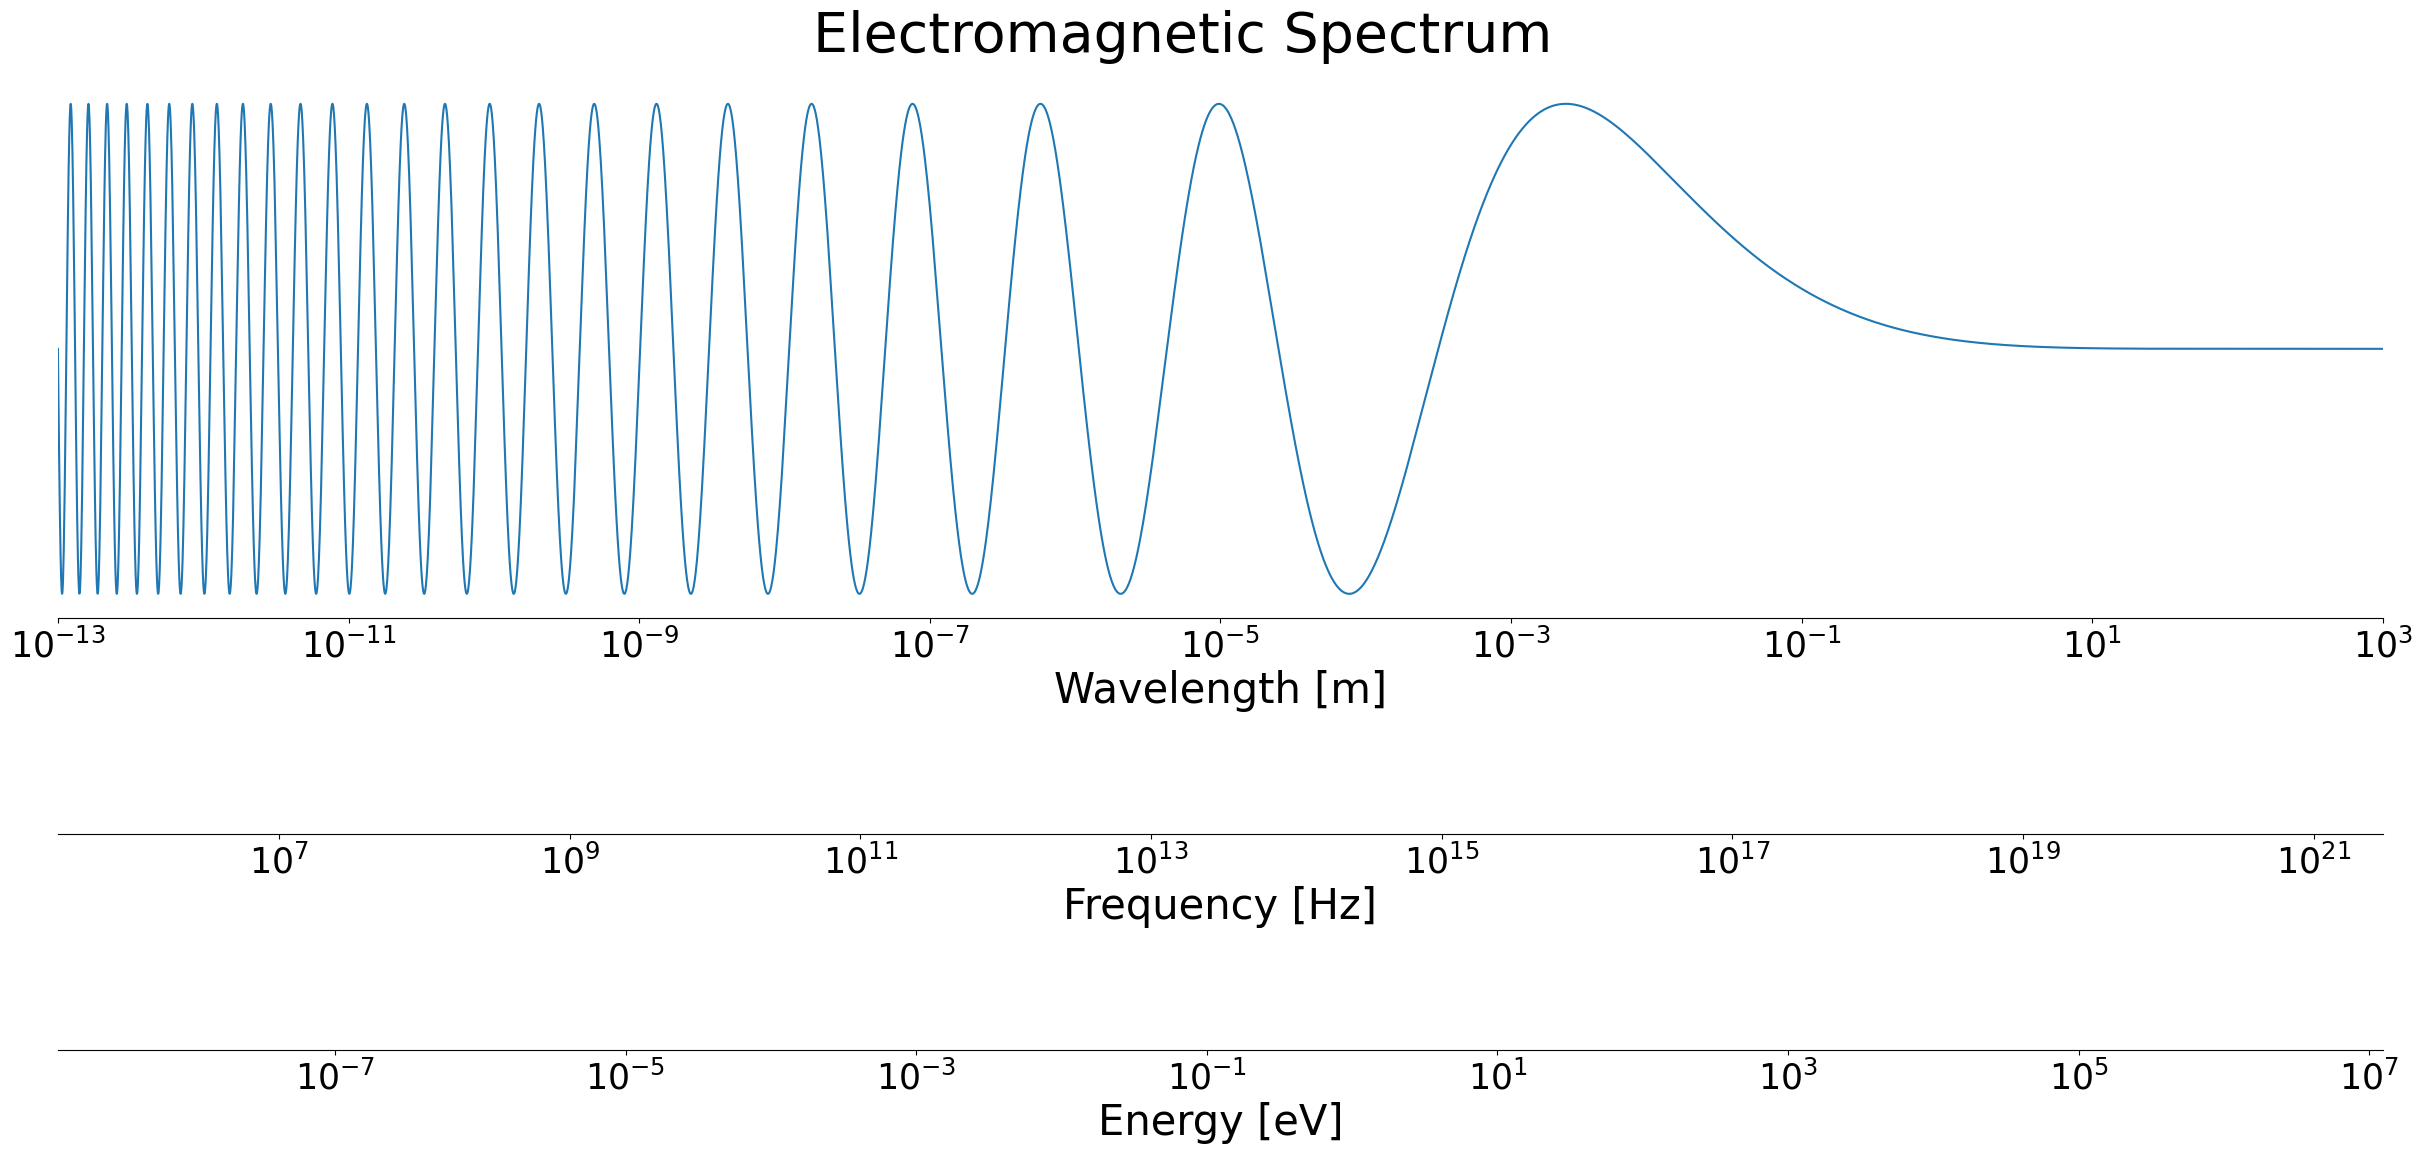

<Figure size 3000x300 with 0 Axes>

In [6]:

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

# one for wavelength (in meters), one for frequency (in Hz), one for energy (in eV)
fig = plt.figure(figsize=(30,7))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twiny()

ax = [ax1, ax2, ax3]
i = 0
offset = 0.4
for a in [ax2, ax3]:
    a.xaxis.set_ticks_position("bottom")
    a.xaxis.set_label_position("bottom")
    a.spines["bottom"].set_position(("axes", i-offset))
    i-=offset
# wavelengths = np.linspace(1e2, 1e-13, 10000)
# frequencies = np.linspace(1e6, 1e25,10000)
lmin, lmax = 250, 1000
wlmin, wlmax = 1e3, 1e-13
flmin, flmax = 1e6, 1e25
xw = powspace(wlmin, wlmax, 10, 100000)
xf = 3e8/xw
h = 4.136e-15
ev = h * xf 

plt.figure(figsize=(30,3))
# A wave with a smoothly increasing wavelength
wv = (np.sin( 10*np.pi * xw / (2*1e2+1e3-xw)))[::-1] + 10
ax1.plot(xw, wv)
ax1.set_xlabel("Wavelength [m]")
ax1.set_xscale('log')
ax1.set_xlim(min(xw), max(xw))
ax2_xticks = np.logspace(5, 21, 20)
ax3_xticks = np.logspace(-9, 7, 17)
ax3.set_xticklabels(ax3_xticks)
ax3.set_xscale('log')
ax3.set_xlabel('Energy [eV]')

ax2.set_xticklabels(ax2_xticks)
ax2.set_xscale('log')
ax2.set_xlabel('Frequency [Hz]')

ax2.set_xlim(min(xf), max(xf))
ax3.set_xlim(min(ev), max(ev))

for _ in ax:
    
    _.spines['top'].set_visible(False)
    _.spines['right'].set_visible(False)
    _.spines['left'].set_visible(False)
    _.get_yaxis().set_visible(False)

fig.suptitle("Electromagnetic Spectrum")



# Q2. Dealing with Data from Multiple Sources - adding passbands and atmospheric transmission (30 pts)

### 2.1
Get the Optical Atmospheric Transmission using the `specreduce` package
    `pip install specreduce`
    https://specreduce.readthedocs.io/en/latest/extinction.html

Note that the optical transmission curves do not include the effect of molecules as the website tells you.
Follow their instructions to add 2.3mm of Preciptiable Water Vapr at an Airmass of 1.0 to the optical transmission. 

Get NIR and MIR transmission curves from here (we're not using MIR this week, but you'll use this code next HW as well)
	http://www.gemini.edu/sciops/telescopes-and-sites/observing-condition-constraints/ir-transmission-spectra
(Cerro Pachon, 2.3mm of Precipitable Water Vapor, Airmass 1.0)


### 2.2
Get the LSST Filter Transmissions (ugrizy, filter only) from here:
http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse

and the IRTF (\[JHK\]_MK, filter only) transmissions from here:
https://irtfweb.ifa.hawaii.edu/~nsfcam2/Filter_Profiles.html

## !Please note that the filter tranmissions are determined by counting photons, not measuing energy! 

In [7]:
from astropy.io import ascii
transmission = ['Optical', 'NIR', 'MIR']
passbands = ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'K']
transmission_files = ['data/2.3mm_pwv_transmission.txt', 
                'data/cptrans_zm_23_10.dat.txt',
                'data/cptrans_nq_23_10.dat.txt']
passband_files = []
passband_files.extend([f"data/LSST_LSST.{i}_filter.dat" for i in ['u', 'g', 'r', 'i', 'z', 'y']])
passband_files.extend([f"data/nsfcam_{i}mk_trans.dat.txt" for i in ['j','h','k']])
transmission_to_file = dict(zip(transmission, transmission_files))
passband_to_file = dict(zip(passbands, passband_files))
# read in all data
# LSSTg = ascii.read("data/cptrans_nq_23_10.dat.txt", names=['wavelength', 'transmission']).to_pandas() 
# LSSTg

In [8]:
trans_data = pd.DataFrame()
for name in transmission:
    file = transmission_to_file[name]
    d = ascii.read(file, names=[f'{name}_wavelength', f'{name}_transmission']).to_pandas()
    trans_data = pd.concat([trans_data, d], axis=1)

passband_data = pd.DataFrame()
for name in passbands:
    file = passband_to_file[name]
    d = ascii.read(file, names=[f'{name}_wavelength', f'{name}_passband']).to_pandas()
    passband_data = pd.concat([passband_data, d], axis=1)

In [9]:
filter_in_micron = ['NIR', 'MIR', 'J', 'H', 'K']
for filt in filter_in_micron:
    if filt in transmission:
        trans_data[f'{filt}_wavelength'] = trans_data[f'{filt}_wavelength']*1e4
    else:
        passband_data[f'{filt}_wavelength'] = passband_data[f'{filt}_wavelength']*1e4

### 2.3

Finally, get the SEDs of three stars from CALSPEC:
https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/calspec
and for the actual data:
https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/

(There is no M5V but there is a M3.5V star - BD-11 3759)


Finally, reconstruct a plot like this (set the wavelength ranges appropriately for the filters I've listed)
<img src="https://www.researchgate.net/profile/C-Chiosi/publication/1925441/figure/fig1/AS:339731901632519@1458009805844/The-filter-sets-used-in-the-present-work-From-top-to-bottom-we-show-the-filter-detector.png">

except replace the middle panel with the atmospheric transmission from your interpolator.

Something like this for the atmosphere plot (but until the wavelength you need): 
<img src="https://www.researchgate.net/profile/Joseph-Shaw-3/publication/260940640/figure/fig3/AS:296902361927680@1447798447054/Atmospheric-transmittance-versus-wavelength-calculated-with-Modtran5-for-a-zenith.png">

In [10]:
from astropy.io import fits
stars = ['Sun', 'BD-11 3759', 'Vega']
star_data= pd.DataFrame()
star_files = ['data/sun_reference_stis_002.fits','data/bd11d3759_stis_003.fits','data/alpha_lyr_stis_011.fits']
star_to_file = dict(zip(stars, star_files))

for name in stars:
    file = star_to_file[name]
    a = fits.open(file)[1].data
    d = pd.DataFrame(np.array(a.tolist())[:, :2], columns = [f'{name}_wavelength', f'{name}_flux'])
    star_data = pd.concat([star_data, d], axis=1)

Text(0.5, 0, 'Wavelength (angstroms)')

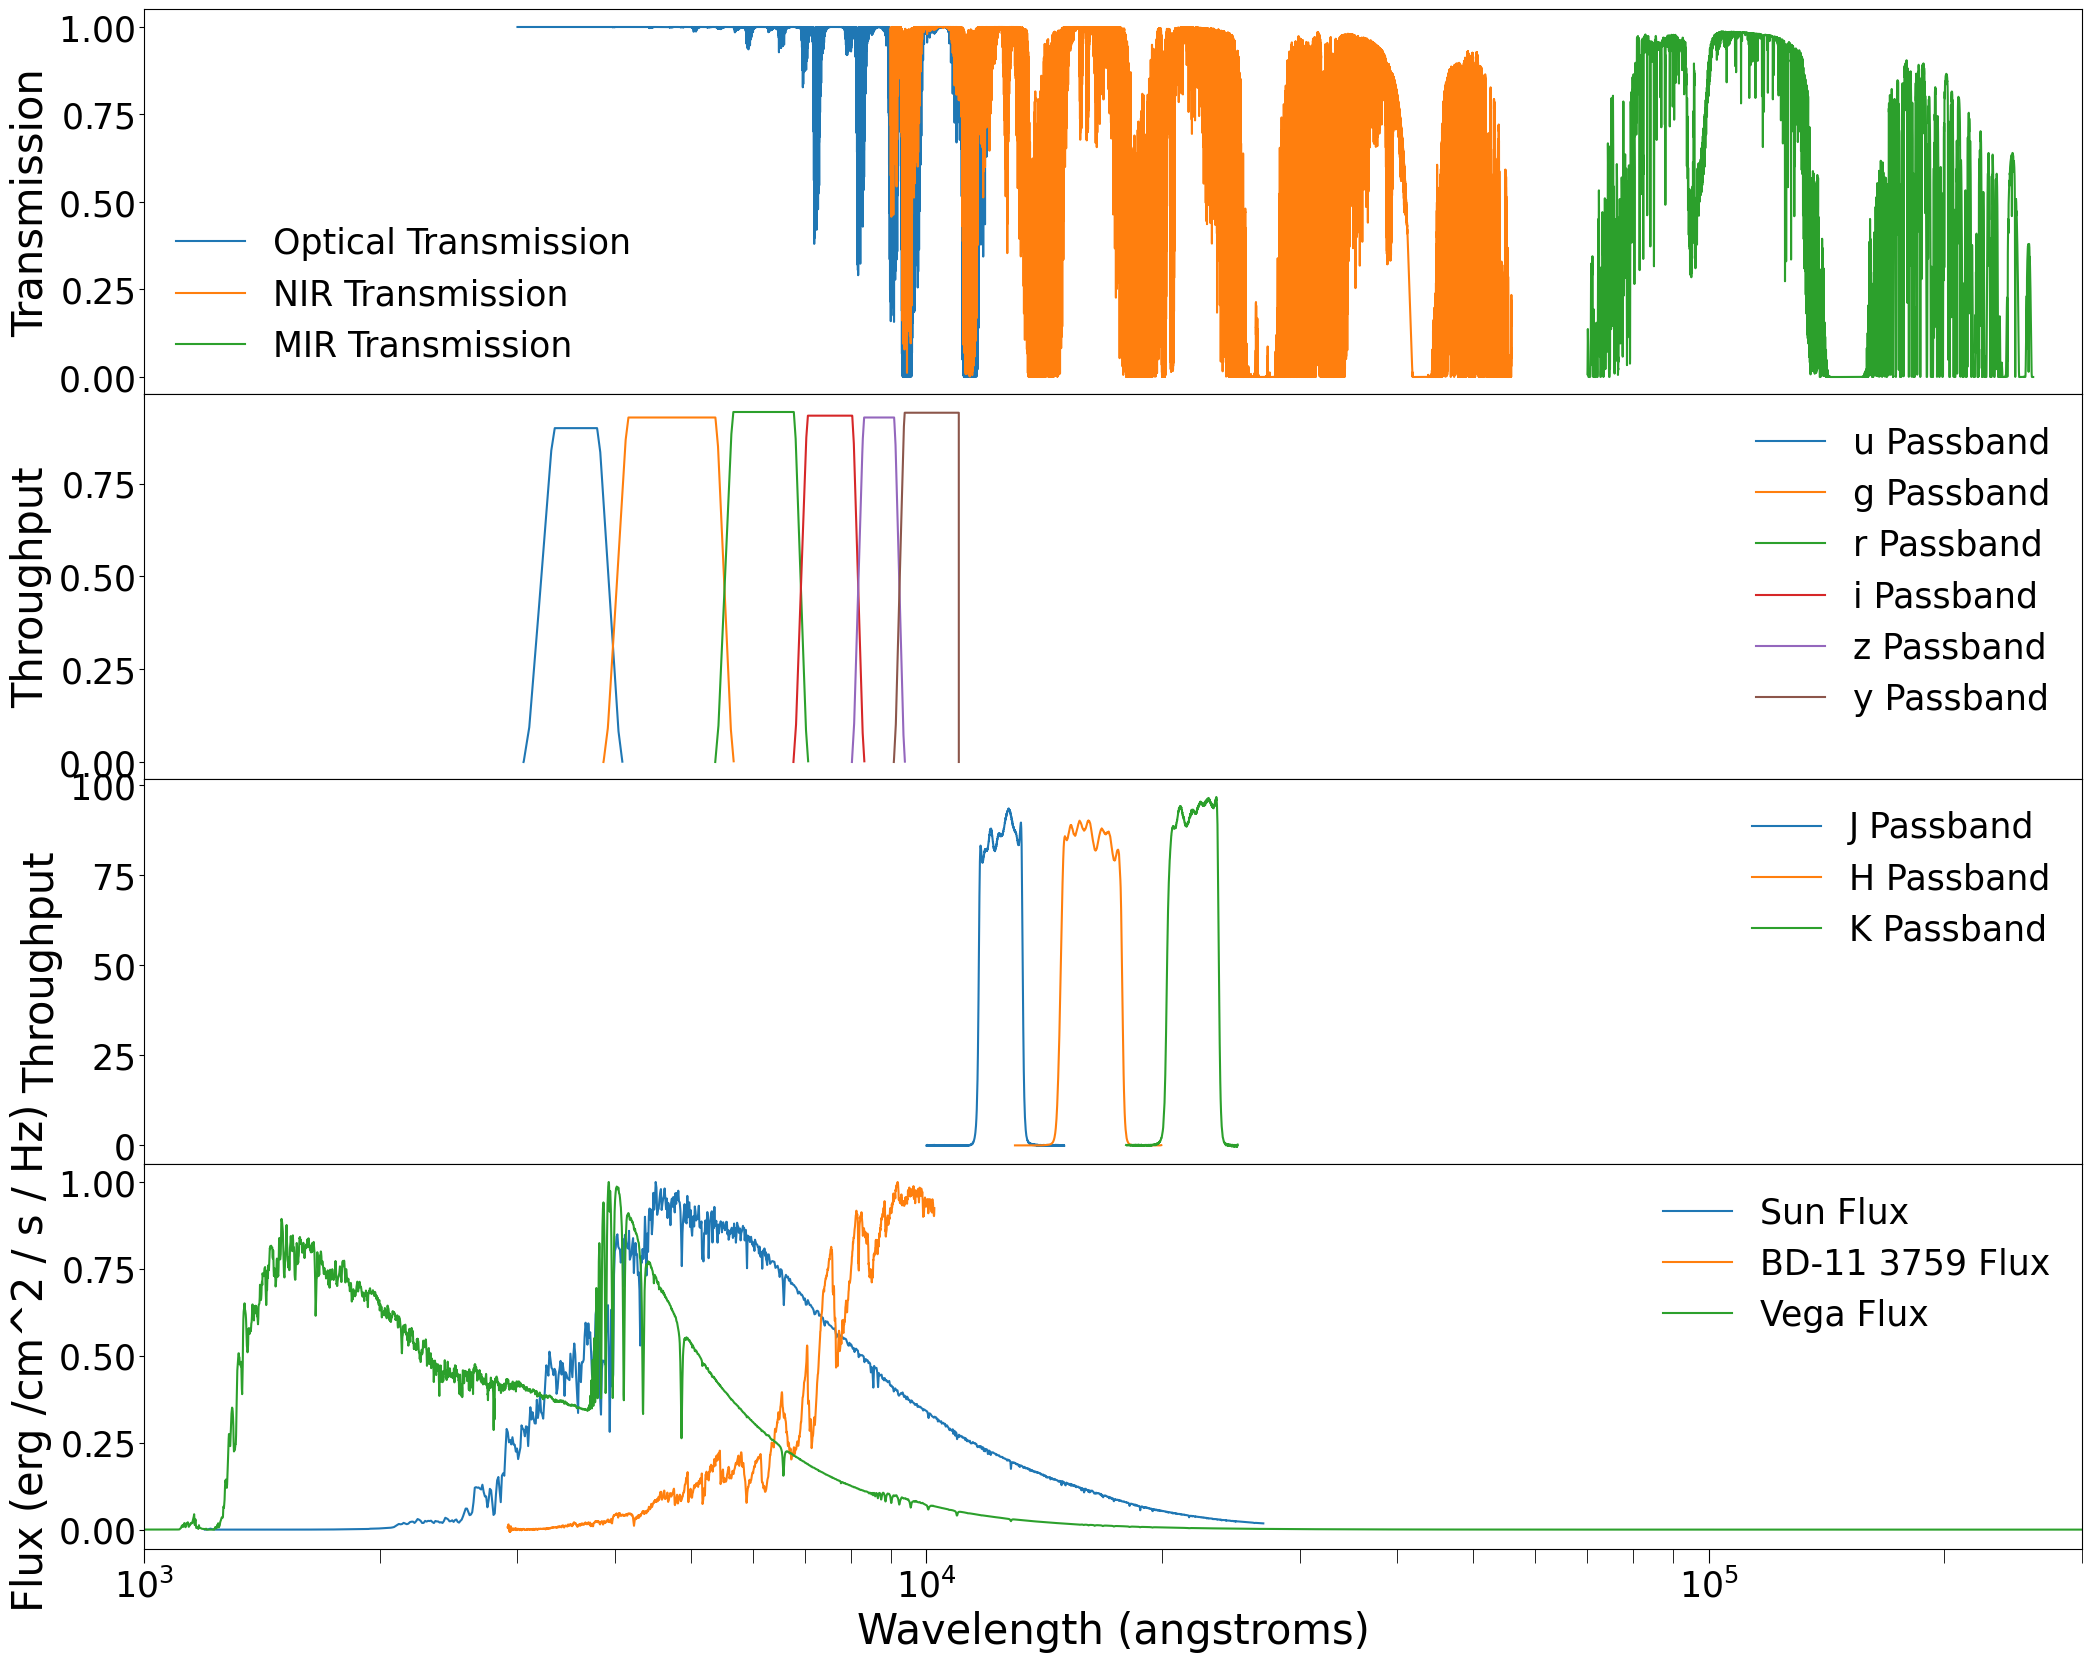

In [12]:
fig = plt.figure(figsize = (25, 20))
gspec = fig.add_gridspec(4, hspace=0)
(ax1, ax2, ax3, ax4) = gspec.subplots(sharex=True, sharey=False)
for filt in transmission[0:3]:
    ax1.plot(trans_data[f'{filt}_wavelength'], trans_data[f'{filt}_transmission'],label=f'{filt} Transmission' )
    ax1.legend(framealpha=0);
    ax1.set_xscale('log')
    ax1.set_xlim(1e3, 3e5)
    ax1.set_ylabel("Transmission")
    

for filt in passbands[0:6]:
    ax2.plot(passband_data[f'{filt}_wavelength'], passband_data[f'{filt}_passband'],label=f'{filt} Passband' )
    ax2.legend(framealpha=0);
    ax2.set_xscale('log')
    ax2.set_ylabel("Throughput")

for filt in passbands[6:]:
    ax3.plot(passband_data[f'{filt}_wavelength'], passband_data[f'{filt}_passband'],label=f'{filt} Passband' )
    ax3.legend(framealpha=0);
    ax3.set_xscale('log')
    ax3.set_ylabel("Throughput")
    
for filt in stars[:3]:
    ax4.plot(star_data[f'{filt}_wavelength'], star_data[f'{filt}_flux']/np.max(star_data[f'{filt}_flux']),label=f'{filt} Flux' )
    ax4.legend(framealpha=0);
    ax4.set_xscale('log')
    ax4.tick_params(axis='x',which='both',length=10)
    ax4.set_ylabel("Flux (erg /cm^2 / s / Hz)")
# for filt 
ax4.set_xlabel("Wavelength (angstroms)")


# Q3. Combine the filter transmission and your atmosphere transmission - we'll assume the mirror and CCDs are perfect over the entire wavelength range. Implement the integrals for flux and magnitude discussed in Lecture 3 as python code. (40 pts)

- You'll have to do something to `interpolate` measurements continuously across the full wavelength range you have across Optical to NIR (you can ignore the MIR file for now, but you'll want it next week)
- Make sure the units are consistent for both wavelength and transmission before you write your interpolator or address differences in some other way 
- You'll need to make sure your interpolator can match the wavelength spacing of the SEDs in Q2
- Rememeber that the intergrals intclude the transmission $T(\lambda)$, which is not normalized properly, so make sure to normalize your integral appropriately
- Normalize the synthetic flux in two ways
    1. such as Vega has magnitude 0 in each band.
    2. such that a synthetic AB source has magnitude 0 in each band

Report the magitudes of the Sun and BD-11 3759 in the Vega and AB system, and the AB magnitudes of Vega in a table (columns = passbands, rows = star/system)

- 15 pts each for the Sun and BD-11 3759 (2 pts for the six optical bands, 1 pt each for JHK) 
- 10 pts for the AB mags of Vega (yes, I know there are 9 bands, not 10, but you can have the one extra)

In [14]:
def get_F_lambda_AB(wavelength):
    fnu = 3.631e-20
    c = 3e18
    flambda = fnu*c/wavelength**2
    return flambda

def get_F_lambda_Vega(wave_input, p):
    wave = star_data['Vega_wavelength']
    passband_data_slice = passband_data[[f'{p}_wavelength', f'{p}_passband']].sort_values(by=f'{p}_wavelength')
    pass_wave = passband_data_slice[f'{p}_wavelength']
    WA, WB = np.min(pass_wave), np.max(pass_wave)
    ind  = np.where((wave >= WA) & (wave <= WB))[0]
    return np.interp(wave_input, star_data['Vega_wavelength'][ind], star_data['Vega_flux'][ind], left=0., right=0.)
    


In [15]:
index = [i + ' (AB mag)' for i in stars]
index.extend([i + ' (Vega mag)' for i in stars])
q3_table = pd.DataFrame(index = index, columns = passbands)
q3_table

,u,g,r,i,z,y,J,H,K
Sun (AB mag),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BD-11 3759 (AB mag),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vega (AB mag),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sun (Vega mag),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BD-11 3759 (Vega mag),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vega (Vega mag),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
import io

In [66]:
transmission_filts = np.array(['Optical', 'NIR'])
passbands = np.array(['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'K'])
for st in stars:
    # let's see if we can get the sun's AB mag in LSST u-band
    wave = star_data[f'{st}_wavelength']
    for p in passbands:
        passband_data_slice = passband_data[[f'{p}_wavelength', f'{p}_passband']].sort_values(by=f'{p}_wavelength')
        pass_wave = passband_data_slice[f'{p}_wavelength']
        WA, WB = np.min(pass_wave), np.max(pass_wave)

        ind  = np.where((wave >= WA) & (wave <= WB))[0]
        # print(ind)

        throughput = passband_data_slice[f'{p}_passband']
        atm_wave = trans_data['Optical_wavelength']
        atm_trans = trans_data['Optical_transmission']

        nir_wave = trans_data['NIR_wavelength']
        nir_trans = trans_data['NIR_transmission']

        ptransmission = np.interp(wave[ind], pass_wave, throughput, left=0., right=0.)
        atransmission = np.interp(wave[ind], atm_wave, atm_trans, left=0., right=0.)
        ntransmission = np.interp(wave[ind], nir_wave, nir_trans, left=0., right=0.)
        #print(st, p, np.sum(np.interp(wave[ind], nir_wave, nir_trans, left=0., right=0.)))
        if np.sum(atransmission)==0 or np.isnan(np.sum(atransmission)):
            atransmission=1
        if np.sum(ntransmission)==0:
            ntransmission=1
        
        n = np.trapz(star_data[f'{st}_flux'][ind]*atransmission*ptransmission*ntransmission,wave[ind])
        for mode in ['AB', 'Vega']:
            if mode =='AB':
                flux_norm = get_F_lambda_AB(wave[ind])
            else:
                flux_norm = get_F_lambda_Vega(wave[ind], p)
            d = np.trapz(flux_norm*atransmission*ptransmission*ntransmission, wave[ind])
            flux_p = n/d
            q3_table.loc[st + f' ({mode} mag)', p] = -2.5*np.log10(flux_p)

/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_68593/957891134.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  n = np.trapz(star_data[f'{st}_flux'][ind]*atransmission*ptransmission*ntransmission,wave[ind])
/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_68593/957891134.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  d = np.trapz(flux_norm*atransmission*ptransmission*ntransmission, wave[ind])
/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_68593/957891134.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  d = np.trapz(flux_norm*atransmission*ptransmission*ntransmission, wave[ind])
/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_68593/957891134.py:30: Deprecati

In [67]:
q3_table

,u,g,r,i,z,y,J,H,K
Sun (AB mag),-25.179789,-26.447298,-26.926919,-27.038778,-27.049957,-27.054043,-27.010734,-26.880488,-26.410788
BD-11 3759 (AB mag),14.911974,12.141851,10.73106,9.206136,8.259804,8.121851,8.026833,NaN,NaN
Vega (AB mag),0.84147,-0.111114,0.140695,0.370853,0.52072,0.611132,0.929088,1.364913,1.889446
Sun (Vega mag),-26.020785,-26.335969,-27.067527,-27.408856,-27.574603,-27.666368,-27.940157,-28.245428,-28.300596
BD-11 3759 (Vega mag),14.070506,12.25296,10.590349,8.835015,7.735348,7.554613,7.34341,NaN,NaN
Vega (Vega mag),-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Sep 17 at Noon!